In [1]:
import random
import numpy as np
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_text as text
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.models import load_model 
from keras.layers import Input, Concatenate, Dense
from keras.optimizers import Adam
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#Setting up a seed for reproducibility
seed = random.seed(42)

In [3]:
train_data = pd.read_csv('/kaggle/input/cb-final-dataset/cleaned_dataset.csv', header=0)
train_data.head()

,index,id,comment,lable,Text_cleaned
0,0,1,මෙතන ඉන්න එකම අවජාතකයා තෝ ! තෝ වගේ මෝඩ ගොබ්බයො...,Sexism,මෙතන ඉන්න එකම අවජාතකයා තෝ තෝ වගේ මෝඩ ගොබ්බයො ...
1,1,2,@USER තොට ජන්ද යක් වත් තියේද දන්නේ නෑ තෝ වගේ හ...,Offensive,තොට ජන්ද යක් තියේද දන්නේ තෝ වගේ හාල්මැස්සන් රට...
2,2,3,මුස්ලිම් කරණයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,Racist,මුස්ලිම් කරනයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...
3,3,4,පිස්සා වගේ same to you කිය කිය යද්දි shame on ...,Neutral,පිස්සා වගේ කිය කිය යද්දි කියලා කියවුනේ ම...
4,4,5,"""@NishadiAnuttara මොකක් ද මොකක් ද අැත්තට හෙට😁😁😁""",Neutral,මොකක් මොකක් අැත්තට හෙට


In [4]:
category_count = train_data['lable'].value_counts()

categories = category_count.index

category_count

Neutral      2377
Offensive    1341
Racist       1084
Sexism       1062
Name: lable, dtype: int64

# **Prepare dataset**

Note that I have already cleaned the dataset.

In [5]:
# creates a new column 'encoded_text' in the train_data dataframe, 
# which contains the categorical codes for the 'label' column.

train_data['encoded_text'] = train_data['lable'].astype('category').cat.codes
train_data.head()

,index,id,comment,lable,Text_cleaned,encoded_text
0,0,1,මෙතන ඉන්න එකම අවජාතකයා තෝ ! තෝ වගේ මෝඩ ගොබ්බයො...,Sexism,මෙතන ඉන්න එකම අවජාතකයා තෝ තෝ වගේ මෝඩ ගොබ්බයො ...,3
1,1,2,@USER තොට ජන්ද යක් වත් තියේද දන්නේ නෑ තෝ වගේ හ...,Offensive,තොට ජන්ද යක් තියේද දන්නේ තෝ වගේ හාල්මැස්සන් රට...,1
2,2,3,මුස්ලිම් කරණයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,Racist,මුස්ලිම් කරනයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,2
3,3,4,පිස්සා වගේ same to you කිය කිය යද්දි shame on ...,Neutral,පිස්සා වගේ කිය කිය යද්දි කියලා කියවුනේ ම...,0
4,4,5,"""@NishadiAnuttara මොකක් ද මොකක් ද අැත්තට හෙට😁😁😁""",Neutral,මොකක් මොකක් අැත්තට හෙට,0


In [6]:
train_data['encoded_text'].value_counts()

0    2377
1    1341
2    1084
3    1062
Name: encoded_text, dtype: int64

In [7]:
# drops the first 4 columns (index, id, comment, and lable) from the train_data DataFrame 
# and assigns the resulting DataFrame to train_data.

train_data = train_data.drop(train_data.columns[[0, 1, 2, 3]], axis=1)
train_data.head()

,Text_cleaned,encoded_text
0,මෙතන ඉන්න එකම අවජාතකයා තෝ තෝ වගේ මෝඩ ගොබ්බයො ...,3
1,තොට ජන්ද යක් තියේද දන්නේ තෝ වගේ හාල්මැස්සන් රට...,1
2,මුස්ලිම් කරනයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,2
3,පිස්සා වගේ කිය කිය යද්දි කියලා කියවුනේ ම...,0
4,මොකක් මොකක් අැත්තට හෙට,0


In [8]:
# renames the columns of the pandas DataFrame train_data to "text" and "label".

train_data.columns = ['text', 'label']
train_data.head(3)

,text,label
0,මෙතන ඉන්න එකම අවජාතකයා තෝ තෝ වගේ මෝඩ ගොබ්බයො ...,3
1,තොට ජන්ද යක් තියේද දන්නේ තෝ වගේ හාල්මැස්සන් රට...,1
2,මුස්ලිම් කරනයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,2


In [9]:
# removes any leading whitespaces using the lstrip() method, and returns the cleaned phrase.

def clean_data(phrase):
    phrase = phrase.lstrip()
    return phrase

In [10]:
train_data['text'] = train_data['text'].astype(str)
train_data['text'] = train_data['text'].map(lambda x: clean_data(x))
train_data.head()

,text,label
0,මෙතන ඉන්න එකම අවජාතකයා තෝ තෝ වගේ මෝඩ ගොබ්බයො ...,3
1,තොට ජන්ද යක් තියේද දන්නේ තෝ වගේ හාල්මැස්සන් රට...,1
2,මුස්ලිම් කරනයෙන් පවුල රැකගන්නට වෙහෙසෙන අපේ කෙල...,2
3,පිස්සා වගේ කිය කිය යද්දි කියලා කියවුනේ ම...,0
4,මොකක් මොකක් අැත්තට හෙට,0


In [11]:
train_data.to_csv("train_data_cleaned.csv", index=False)

In [12]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_data.text, target_vocab_size=100000)

In [13]:
train_inputs = [tokenizer.encode(sentence) for sentence in train_data.text]

In [14]:
# Get the vocabulary size from the tokenizer
vocab_size = tokenizer.vocab_size

# Create a dictionary that maps each subword to its index in the tokenizer
word_index = {subword: index+1 for index, subword in enumerate(tokenizer.subwords)}

In [15]:
embedding_dim = 300

In [16]:
# Loading pretrained FastText word embeddings in Sinhala
import fasttext
import fasttext.util
ft = fasttext.load_model('/kaggle/input/fast-text/cc.si.300.bin')
ft.get_dimension()

# Mapping FastText word vectors with word in the dataset 
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [17]:
# sets the maximum length of the sentences in a dataset, and pads the sentences with zeros 
# to the same length to ensure consistency when using them to train or test a model.

MAX_LEN = max([len(sentence) for sentence in train_inputs])
# Pad the training data
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    train_inputs, value=0, padding="post", maxlen=MAX_LEN)

In [18]:
# saves the train_inputs and test_inputs arrays as binary files using the pickle module, 
# which can be loaded later for use in training or testing machine learning models.

with open('train_inputs', 'wb') as fh:
   pickle.dump(train_inputs, fh)

In [19]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_inputs, train_data.label, test_size=0.2, random_state=seed)

# **Building the model**

In [21]:
# Define the hyperparameters
VOCAB_SIZE = 5297
EMB_DIM = 300
NB_CLASSES = 4
DROPOUT_RATE = 0.1
EPOCHS = 8
BATCH_SIZE = 32

In [22]:
def DCNNModel(embeddings_matrix,
              vocab_size,
              emb_dim=300,
              nb_filters=100,
              FFN_units=256,
              nb_classes=4,
              dropout_rate=0.1,
              training=False,
              name="DCNN"):
    
    inputs = layers.Input(shape=(None,), name="input")
    x = layers.Embedding(vocab_size, emb_dim, weights=[embeddings_matrix],
                         trainable=False, name="embedding")(inputs)
    
    # Convolutional layers
    conv1 = layers.Conv1D(filters=nb_filters,
                          kernel_size=2,
                          padding="valid",
                          activation="relu",
                          name="conv1")(x)
    conv1 = layers.GlobalMaxPool1D(name="pool1")(conv1)
    
    conv2 = layers.Conv1D(filters=nb_filters,
                          kernel_size=3,
                          padding="valid",
                          activation="relu",
                          name="conv2")(x)
    conv2 = layers.GlobalMaxPool1D(name="pool2")(conv2)
    
    x = layers.concatenate([conv1, conv2], axis=-1, name="concat")
    
    # Feedforward neural network layers
    x = layers.Dense(units=FFN_units, activation="relu", name="dense")(x)
    # Dropout is only applied during training to prevent overfitting
    x = layers.Dropout(rate=dropout_rate, name="dropout")(x, training=training)
    
    # Output layer
    outputs = layers.Dense(units=nb_classes, activation="softmax", name="output")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    
    return model

In [23]:
dcnn_model = DCNNModel(embeddings_matrix,vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=100,
            FFN_units=256,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE,
            training=False,
            name="dcnn")

In [24]:
 dcnn_model.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["accuracy"])

In [25]:
filepath="dcnn_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [26]:
dcnn_history = dcnn_model.fit(X_train, 
                 y_train,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS, validation_data=(X_test, y_test), callbacks = callbacks_list)

Epoch 1/8
147/147 [==============================] - ETA: 0s - loss: 1.1312 - accuracy: 0.5214
Epoch 1: val_accuracy improved from -inf to 0.65926, saving model to dcnn_model.h5
147/147 [==============================] - 49s 322ms/step - loss: 1.1312 - accuracy: 0.5214 - val_loss: 0.8557 - val_accuracy: 0.6593
Epoch 2/8
147/147 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.6962
Epoch 2: val_accuracy improved from 0.65926 to 0.72494, saving model to dcnn_model.h5
147/147 [==============================] - 47s 318ms/step - loss: 0.7881 - accuracy: 0.6962 - val_loss: 0.7089 - val_accuracy: 0.7249
Epoch 3/8
147/147 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7455
Epoch 3: val_accuracy improved from 0.72494 to 0.76148, saving model to dcnn_model.h5
147/147 [==============================] - 46s 313ms/step - loss: 0.6665 - accuracy: 0.7455 - val_loss: 0.6040 - val_accuracy: 0.7615
Epoch 4/8
147/147 [==============================] - ETA: 

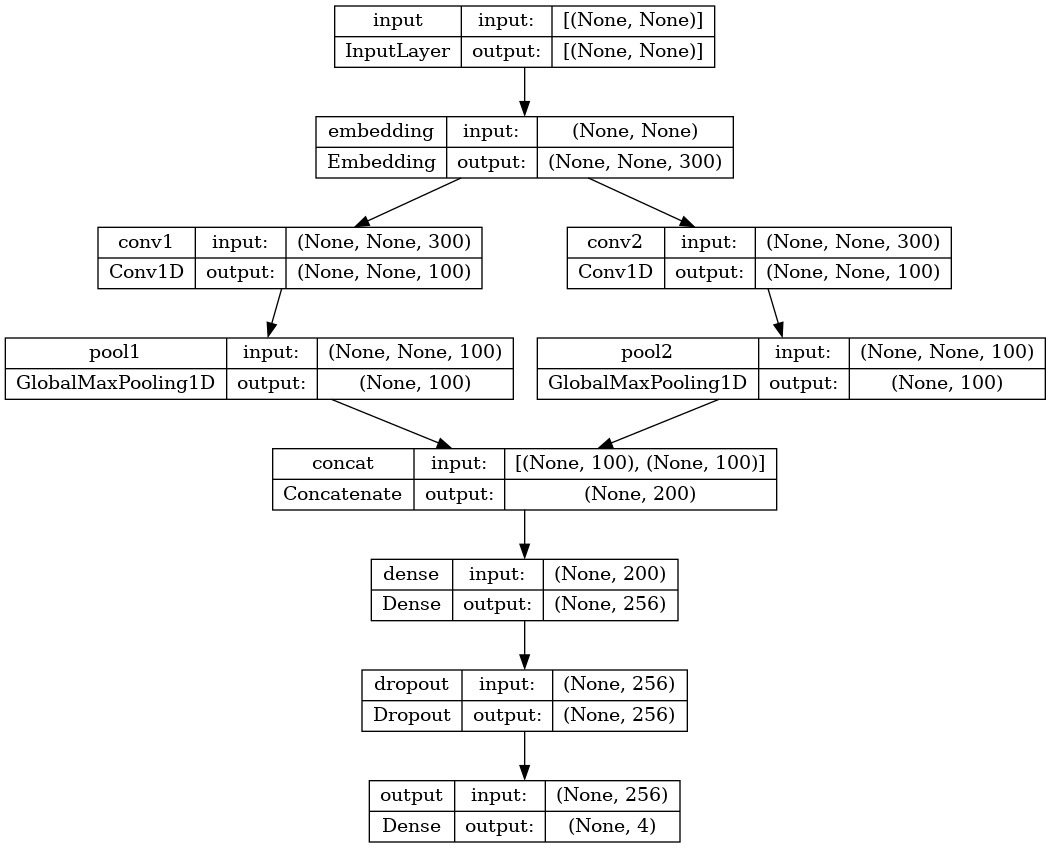

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(dcnn_model, to_file='model.png',show_shapes=True, show_layer_names=True, expand_nested=True)

# **Evaluation**

In [28]:
dcnn = tf.keras.models.load_model('dcnn_model.h5')

In [29]:
train_loss, train_acc = dcnn.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
val_loss, val_acc = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print('Training loss: {}, Training accuracy: {}'.format(train_loss, train_acc))
print('Validation loss: {}, Validation accuracy: {}'.format(val_loss, val_acc))

64/64 [==============================] - 7s 103ms/step - loss: 0.3011 - accuracy: 0.9096
Training loss: 0.18264074623584747, Training accuracy: 0.9541675448417664
Validation loss: 0.3010711669921875, Validation accuracy: 0.9096296429634094


In [30]:
output = dcnn(np.array([tokenizer.encode("දෙමලු.තම්බි රටෙන් එලවන්ට එකග උන් කොො")]), training=False).numpy()
highest_index = np.argmax(output)
print(output)

# Calculate the sum of the output array
sum_output = sum(output[0])

for i in range(len(output[0])):
    output[0][i] = output[0][i] / sum_output * 100
    print(f"Class {i}: {output[0][i]:.2f}%")
print("")
print("Heighest match: Class " , highest_index)

[[3.2983811e-05 4.5888752e-05 9.9990904e-01 1.1980504e-05]]
Class 0: 0.00%
Class 1: 0.00%
Class 2: 99.99%
Class 3: 0.00%

Heighest match: Class  2


In [31]:
output = dcnn(np.array([tokenizer.encode("මෝඩ ගැනි")]), training=False).numpy()
highest_index = np.argmax(output)
print(output)

# Calculate the sum of the output array
sum_output = sum(output[0])

for i in range(len(output[0])):
    output[0][i] = output[0][i] / sum_output * 100
    print(f"Class {i}: {output[0][i]:.2f}%")
print("")
print("Heighest match: Class " , highest_index)

[[0.00458211 0.98837286 0.0023312  0.00471377]]
Class 0: 0.46%
Class 1: 98.84%
Class 2: 0.23%
Class 3: 0.47%

Heighest match: Class  1


In [32]:
# Convert y_train and y_test to one-hot encoded format
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Compile the model
dcnn.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Evaluate the model on the test data
mse, mse_value, mae = dcnn.evaluate(X_test, y_test_one_hot, verbose=0)

# Print the results
print('MSE:', mse_value)
print('MAE:', mae)

MSE: 0.03637683764100075
MAE: 0.08478254824876785


In [33]:
def plot_history(model, history):
    """
    Plots the loss and accuracy graphs for the given model and its training history.
    """
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model.name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model.name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

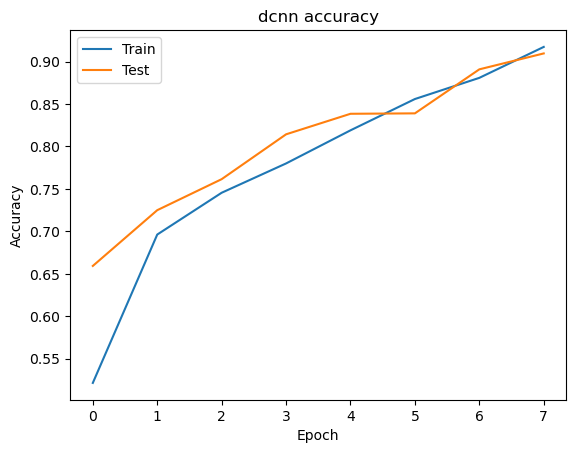

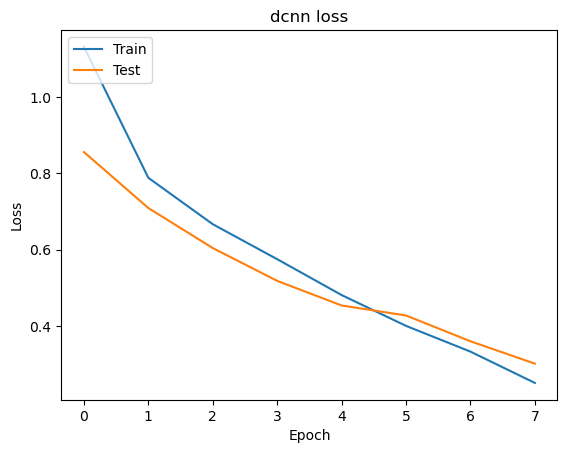

In [34]:
plot_history(dcnn, dcnn_history)

In [37]:
y_pred = dcnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

print(classification_report(y_test, y_pred))

37/37 [==============================] - 4s 106ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       482
           1       0.89      0.84      0.86       273
           2       0.95      0.95      0.95       221
           3       0.78      0.94      0.85       197

    accuracy                           0.90      1173
   macro avg       0.89      0.91      0.90      1173
weighted avg       0.91      0.90      0.90      1173



In [38]:
pred_labels = np.argmax(dcnn.predict(X_test), axis=-1)
conf_mat = confusion_matrix(y_test, pred_labels)
print(conf_mat)

37/37 [==============================] - 4s 104ms/step
[[436  18   9  19]
 [ 14 228   1  30]
 [  4   3 210   4]
 [  2   8   1 186]]
